# **1. Perkenalan Dataset**


356Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
https://www.kaggle.com/datasets/wowevan/dataset-kesejahteraan-pekerja-indonesia?resource=download
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [536]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [537]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

# **3. Memuat Dataset**

In [538]:
gk_df = pd.read_csv('/content/drive/MyDrive/submission2/dataset/garisKemiskinan.csv', delimiter=',')
gk_df.head()

,provinsi,jenis,daerah,tahun,periode,gk
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0


In [539]:
mu_df = pd.read_csv('/content/drive/MyDrive/submission2/dataset/minUpah.csv', delimiter=',')
mu_df.head()

,provinsi,tahun,ump
0,ACEH,2002,330000.0
1,ACEH,2003,425000.0
2,ACEH,2004,550000.0
3,ACEH,2005,620000.0
4,ACEH,2006,820000.0


In [540]:
pe_df = pd.read_csv('/content/drive/MyDrive/submission2/dataset/pengeluaran.csv', delimiter=',')
pe_df.head()

,provinsi,daerah,jenis,tahun,peng
0,ACEH,PERDESAAN,MAKANAN,2007,195176.0
1,ACEH,PERDESAAN,MAKANAN,2008,218781.0
2,ACEH,PERDESAAN,MAKANAN,2009,247427.0
3,ACEH,PERDESAAN,MAKANAN,2010,275749.0
4,ACEH,PERDESAAN,MAKANAN,2011,308000.0


In [541]:
ru_df = pd.read_csv('/content/drive/MyDrive/submission2/dataset/rataRataUpah.csv', delimiter=',')
ru_df.head()

,provinsi,tahun,upah
0,ACEH,2015,11226
1,ACEH,2016,13627
2,ACEH,2017,14809
3,ACEH,2018,13814
4,ACEH,2019,15065


In [542]:
merged_df = gk_df.merge(mu_df, on=["provinsi", "tahun"]) \
                 .merge(pe_df, on=["provinsi", "tahun", "daerah","jenis"]) \
                 .merge(ru_df, on=["provinsi", "tahun"])
merged_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0,2118500.0,548853.0,13627
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0,2118500.0,548853.0,13627
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226


In [543]:
merged_df = merged_df[
    (merged_df["provinsi"] != "INDONESIA") &
    (merged_df["jenis"] != "TOTAL") &
    (merged_df["daerah"] != "PERDESAANPERKOTAAN")
].reset_index(drop=True)

**Insight**:
1. Saya memgabungkan dataset berdasarkan `provinsi`, `tahun`, `jenis`  dan  `daerah`.
2. Saya menghapus baris dengan nilai `INDONESIA`, `TOTAL`, dan `PERDESAANPERKOTAAN` karena bersifat agregat dan tidak merepresentasikan wilayah atau jenis data yang spesifik. Nilai `TOTAL` mencerminkan gabungan dari `MAKANAN` dan `NONMAKANAN`, sehingga saya memilih menggunakan komponen aslinya untuk analisis yang lebih terperinci.

In [544]:
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['tahun', 'gk', 'ump', 'peng', 'upah'], dtype='object')

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

### 1. Memahami Struktur Data

In [545]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  2176 non-null   object 
 1   jenis     2176 non-null   object 
 2   daerah    2176 non-null   object 
 3   tahun     2176 non-null   int64  
 4   periode   2176 non-null   object 
 5   gk        2144 non-null   float64
 6   ump       2176 non-null   float64
 7   peng      2144 non-null   float64
 8   upah      2176 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 153.1+ KB


In [546]:
merged_df.describe(include='all')

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah
count,2176,2176,2176,2176.000000,2176,2144.000000,2.176000e+03,2.144000e+03,2176.000000
unique,34,2,2,NaN,2,NaN,NaN,NaN,NaN
top,ACEH,MAKANAN,PERKOTAAN,NaN,MARET,NaN,NaN,NaN,NaN
freq,64,1088,1088,NaN,1088,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2018.500000,NaN,228034.756530,2.310701e+06,5.701367e+05,16651.562500
std,NaN,NaN,NaN,2.291815,NaN,126370.388039,6.083094e+05,1.781897e+05,4410.468772
min,NaN,NaN,NaN,2015.000000,NaN,48561.000000,9.100000e+05,1.760280e+05,8525.000000
25%,NaN,NaN,NaN,2016.750000,NaN,111752.000000,1.873750e+06,4.342870e+05,13445.500000
50%,NaN,NaN,NaN,2018.500000,NaN,212337.000000,2.267356e+06,5.584700e+05,15856.500000
75%,NaN,NaN,NaN,2020.250000,NaN,327492.500000,2.699206e+06,6.790842e+05,18863.000000


**Insight:**
1. Dataset Gabungan memiliki **2176** baris dengan **9** kolom. **5** kolom numerikal dan **4** kolom kategorikal. **4** kolom bertipe kategori, sementara **5** kolom tipe numerikal.
2. Data yang saya gunakan untuk analisis yaitu data yang di merged

### 2. Menangani Data yang Hilang

In [547]:
print(f"Jumlah data hilang pada dataset: \n{merged_df.isnull().sum()}")

Jumlah data hilang pada dataset: 
provinsi     0
jenis        0
daerah       0
tahun        0
periode      0
gk          32
ump          0
peng        32
upah         0
dtype: int64


In [548]:
merged_df.fillna({'gk': merged_df['gk'].mean(),
                  'peng': merged_df['peng'].mean()}, inplace=True)

In [549]:
print(f"Jumlah data ganda pada dataset: {merged_df.duplicated().sum()}")

Jumlah data ganda pada dataset: 0


**Insight:**
1. Terdapat 32 *missing value* pada kolom `gk` dan `peng`
2. Nilai kosong ini telah diisi menggunakan nilai rata-rata kolom masing-masing (mean imputation).
3. Tidak ada data duplikat dataset.

### 3. Analisis Distribusi dan Korelasi

In [550]:
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['tahun', 'gk', 'ump', 'peng', 'upah'], dtype='object')

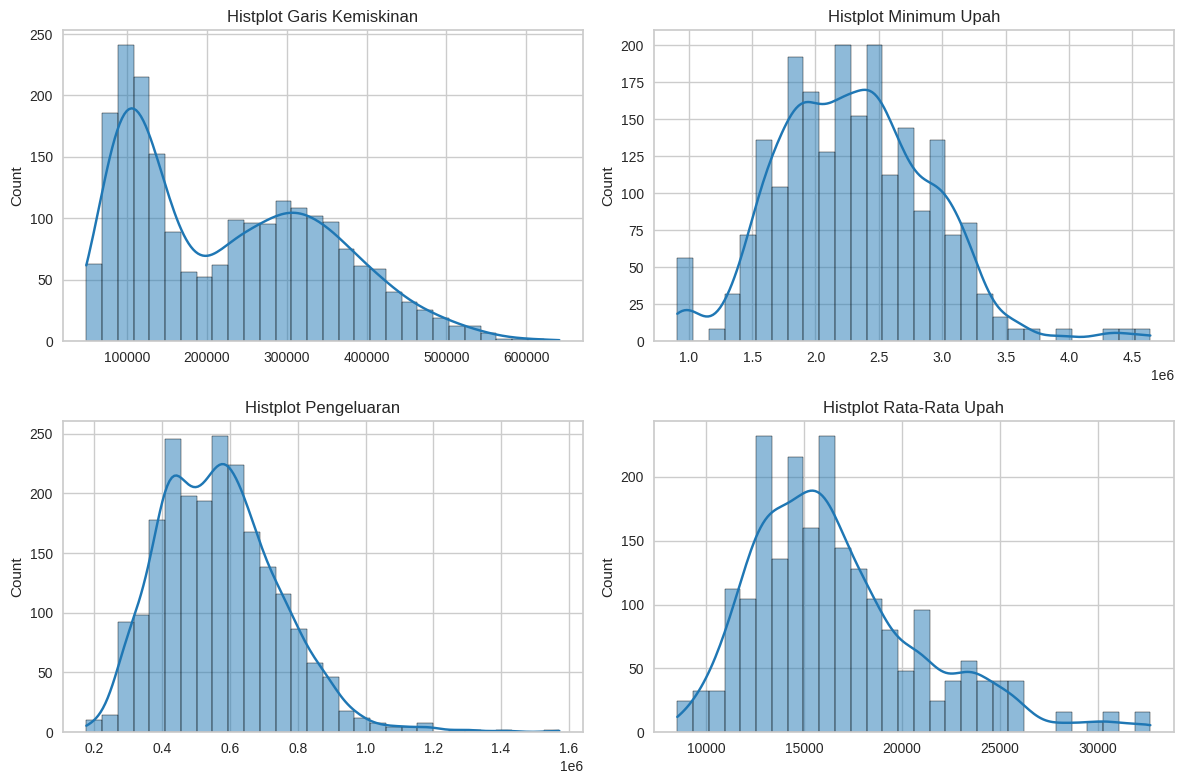

In [551]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.histplot(x=merged_df[col], bins=30, kde=True, color="tab:blue")

    column_name = ""

    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Histplot {column_name}")
    plt.xlabel(None)

plt.tight_layout()
plt.show()

**Insight :**
1. **Garis Kemiskinan (gk)** Distribusi terlihat **right-skewed** (condong ke kiri), menunjukkan sebagian besar wilayah memiliki garis kemiskinan yang relatif rendah, sementara hanya sedikit wilayah dengan garis kemiskinan tinggi
2. **Upah Minimum (ump)** Distribusi **upah rata-rata** dan **UMP** cenderung lebih merata, namun tetap menunjukkan beberapa wilayah dengan nilai tinggi yang dapat menjadi klaster tersendiri.
3. **Pengeluaran (peng)** Distribusinya mirip garis kemiskinan, juga skewed ke kanan, artinya sebagian besar daerah memiliki tingkat konsumsi per kapita yang lebih rendah.
4. **Rata-rata Upah (upah)** Distribusi juga agak skewed ke kanan, meskipun tidak terlalu ekstrem. Mayoritas wilayah memiliki upah antara 10.000–20.000, tapi ada sejumlah kecil daerah dengan upah jauh lebih tinggi.

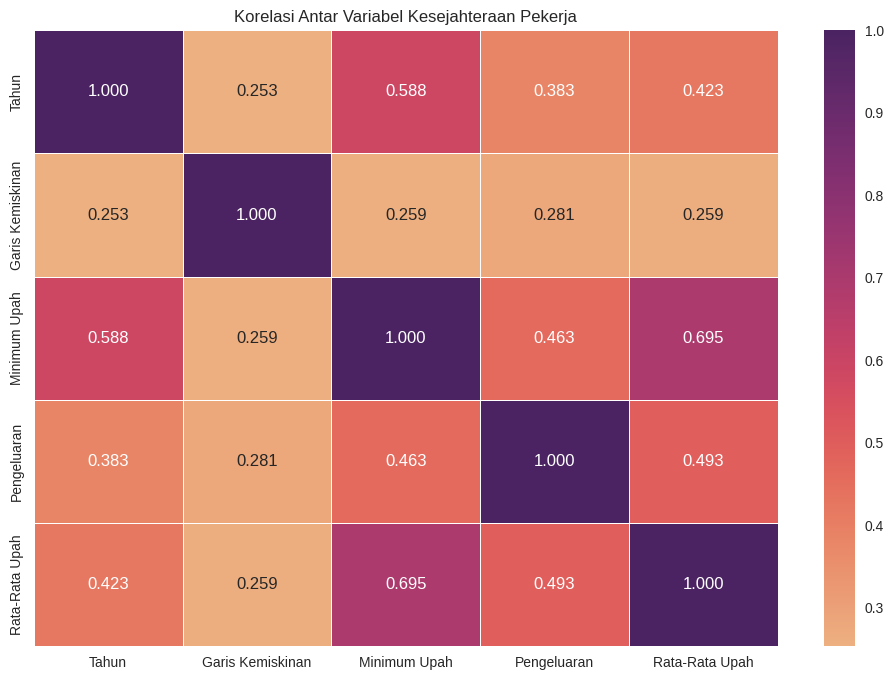

In [552]:
labels = ["Tahun", "Garis Kemiskinan", "Minimum Upah", "Pengeluaran", "Rata-Rata Upah"]

plt.figure(figsize=(12, 8))
sns.heatmap(merged_df[numeric_columns].corr(), annot=True, cmap="flare", fmt=".3f", linewidths=0.5, xticklabels=labels, yticklabels=labels)
plt.title("Korelasi Antar Variabel Kesejahteraan Pekerja")
plt.xlabel(None)
plt.show()

**Insight :**
1. Terdapat hubungan kuat antara `Minimum Upah` dan `Rata-Rata Upah` (0.695), menunjukkan bahwa wilayah dengan UMP tinggi cenderung memiliki tingkat upah pekerja yang juga tinggi.
2. Korelasi sedang juga terlihat antara `Pengeluaran` dengan `Upah` (0.493) dan `UMP` (0.463), yang mengindikasikan bahwa daya beli meningkat seiring naiknya pendapatan.
3. `Garis Kemiskinan` memiliki korelasi rendah terhadap variabel lainnya, menunjukkan bahwa standar kemiskinan tidak selalu naik seiring dengan upah atau pengeluaran, dan bisa dipengaruhi oleh kebijakan lokal atau struktur harga di masing-masing wilayah.

### 4. Visualisasi Data

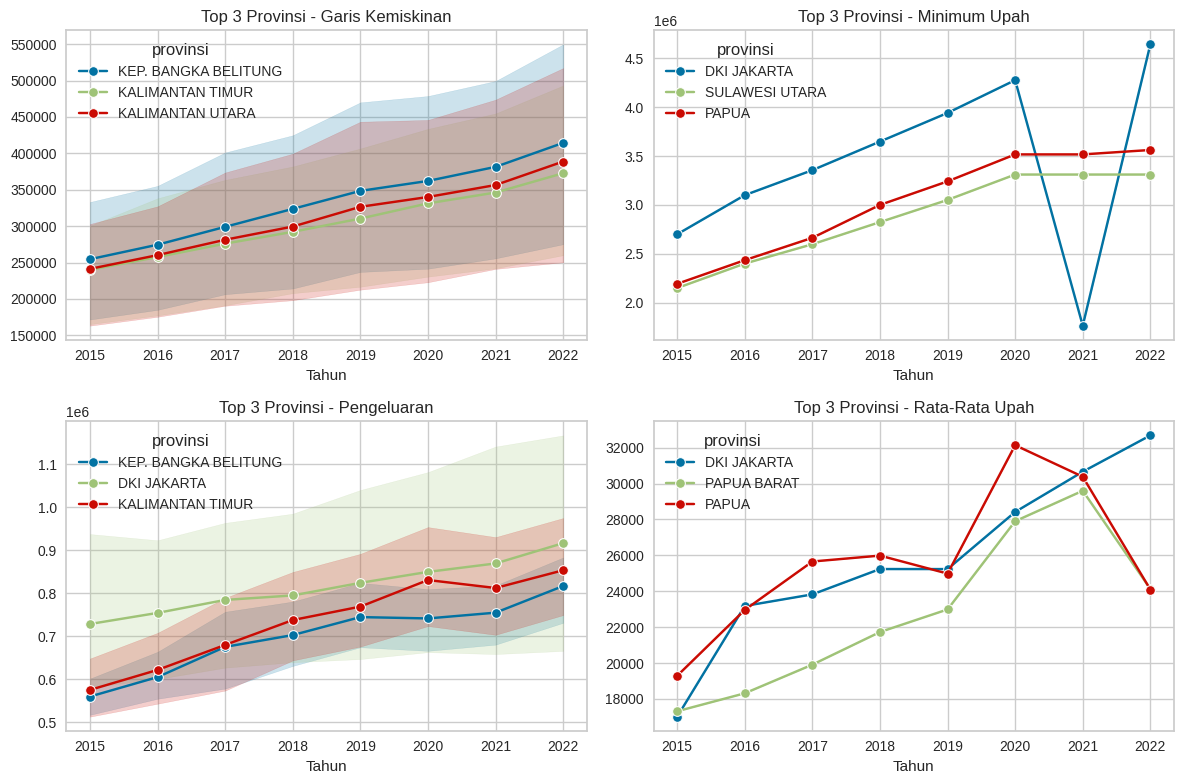

In [553]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)

    top_3 = merged_df.groupby("provinsi")[col].mean().nlargest(3).index.tolist()
    top_df = merged_df[merged_df["provinsi"].isin(top_3)]

    sns.lineplot(
        data=top_df[["tahun", "provinsi", col]],
        x="tahun",
        y=col,
        hue="provinsi",
        marker="o"
    )

    column_name = ""
    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Top 3 Provinsi - {column_name}")
    plt.xlabel("Tahun")
    plt.ylabel(None)

plt.tight_layout()
plt.show()

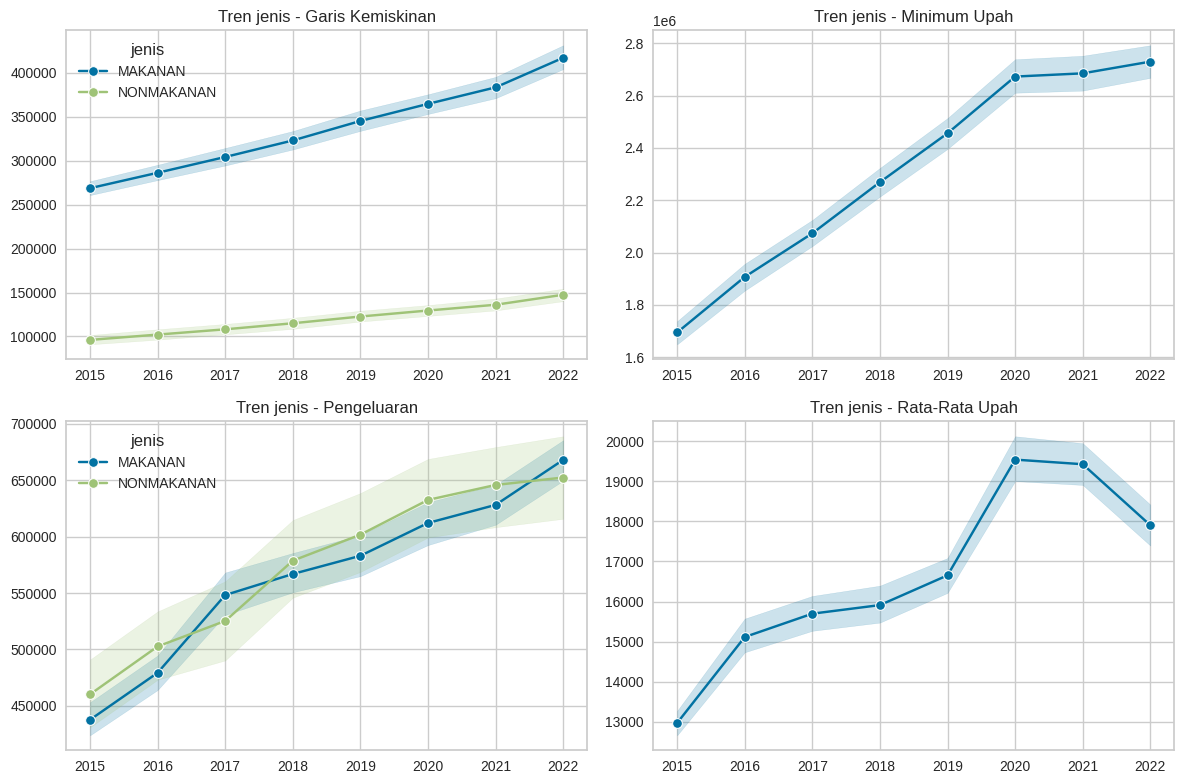

In [554]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)

    sns.lineplot(
        data=merged_df[["tahun", "jenis", col]],
        x="tahun",
        y=col,
        hue="jenis" if i % 2 != 0 else None,
        marker="o"
    )

    column_name = ""
    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Tren jenis - {column_name}")
    plt.xlabel(None)
    plt.ylabel(None)

plt.tight_layout()
plt.show()

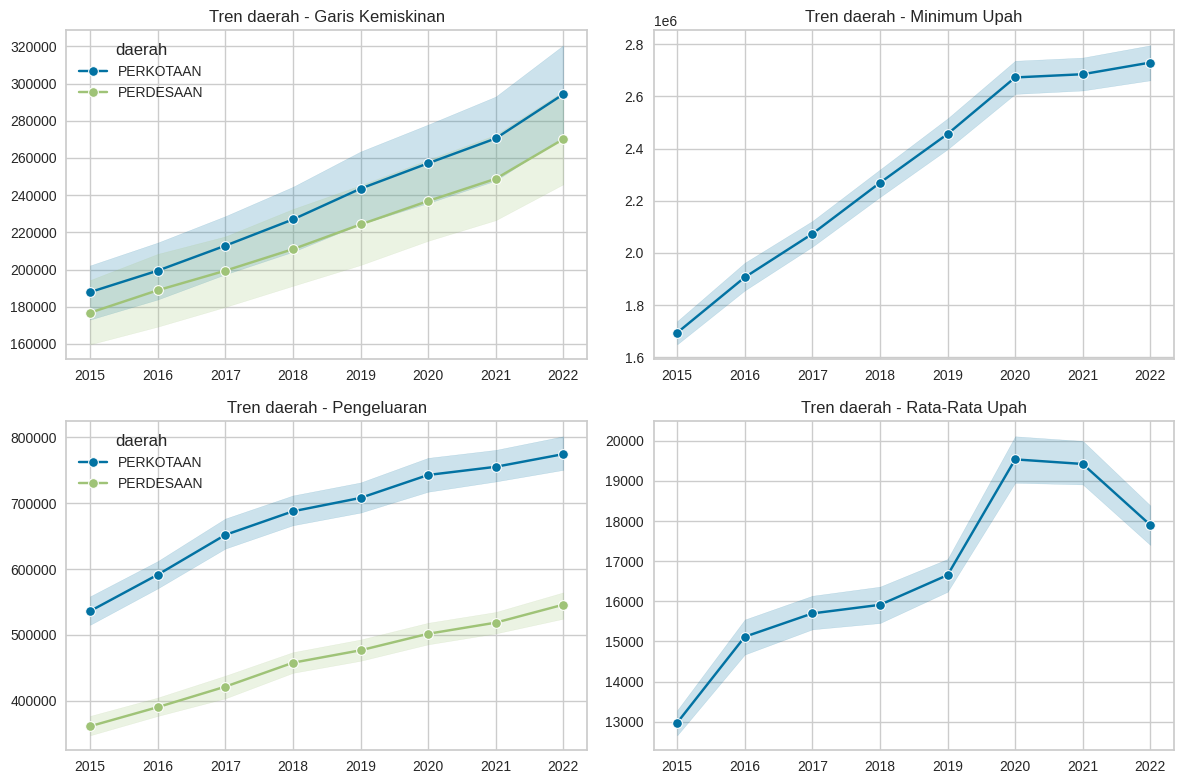

In [555]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)

    sns.lineplot(
        data=merged_df[["tahun", "daerah", col]],
        x="tahun",
        y=col,
        hue="daerah" if i % 2 != 0 else None,
        marker="o"
    )

    column_name = ""
    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Tren daerah - {column_name}")
    plt.xlabel(None)
    plt.ylabel(None)

plt.tight_layout()
plt.show()

**Insight :**
1. Provinsi seperti **DKI Jakarta, Papua,** dan **Kep. Bangka Belitung** secara konsisten mendominasi nilai tertinggi pada variabel `UMP`, `Upah`, `Pengeluaran`, dan `Garis Kemiskinan`.
2. **Papua dan Papua Barat** mencatat lonjakan upah rata-rata yang signifikan, namun juga memiliki fluktuasi tajam, mencerminkan ketidakstabilan ekonomi atau efek dari kebijakan upah sektoral.
3. **Kep. Bangka Belitung** unggul di pengeluaran dan garis kemiskinan, menandakan biaya hidup yang tinggi dibanding daerah lain.
4. Nilai `Garis Kemiskinan `dan `Pengeluaran` untuk kategori makanan jauh lebih tinggi dibanding nonmakanan, konsisten sepanjang tahun.
5. Wilayah **perkotaan** memiliki nilai yang lebih tinggi secara konsisten pada semua variabel (`UMP`, `Upah`, `Pengeluaran`, `Garis Kemiskinan`).

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

1. Menghapus atau Menangani Data Kosong (*Missing Values*)

In [556]:
print(f"Jumlah data hilang pada dataset: \n{merged_df.isnull().sum()}")

Jumlah data hilang pada dataset: 
provinsi    0
jenis       0
daerah      0
tahun       0
periode     0
gk          0
ump         0
peng        0
upah        0
dtype: int64


2. Menghapus Data Duplikat

In [557]:
print(f"Jumlah data ganda pada dataset: {merged_df.duplicated().sum()}")

Jumlah data ganda pada dataset: 0


**Insight:**
1. Tidak ada dataset yang kosong, kerena telah diisi menggunakan nilai rata-rata kolom masing-masing
2. Tidak ada duplicated data pada dataset

3. Normalisasi atau Standarisasi Fitur

In [558]:
merged_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0,2118500.0,548853.0,13627
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0,2118500.0,548853.0,13627
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226


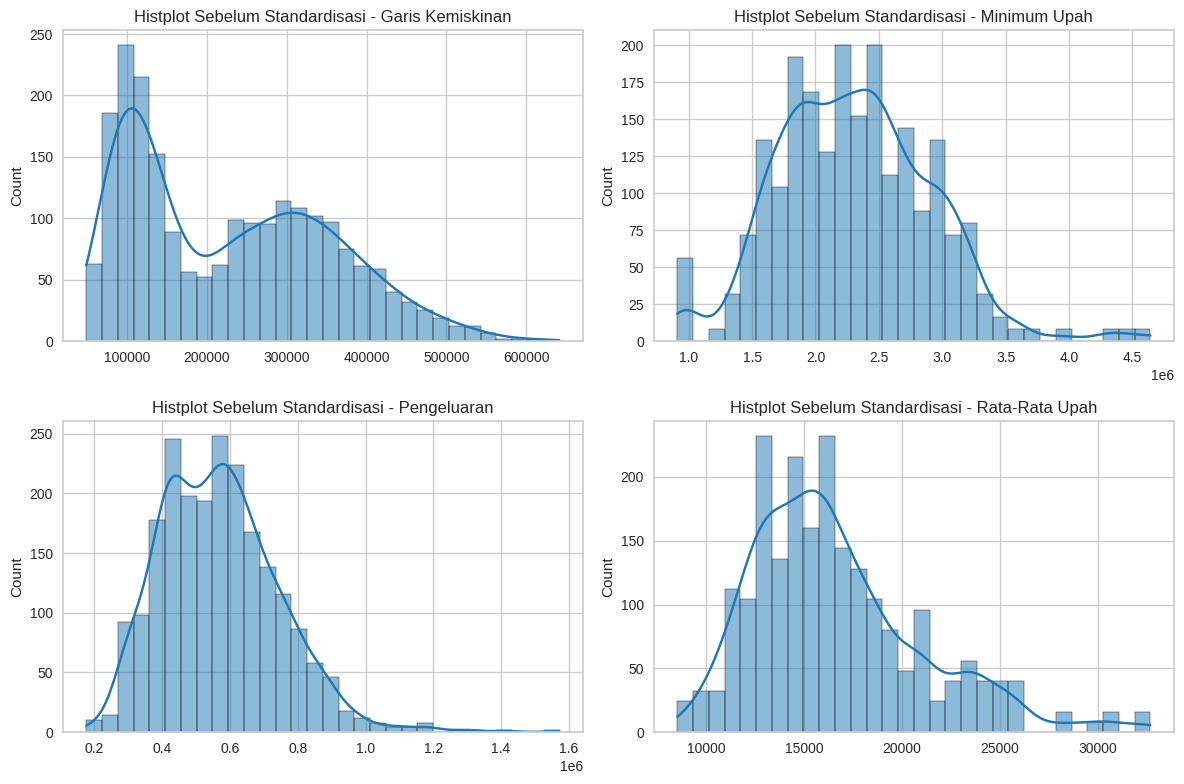

In [559]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.histplot(x=merged_df[col], bins=30, kde=True, color="tab:blue")

    column_name = ""

    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Histplot Sebelum Standardisasi - {column_name}")
    plt.xlabel(None)

plt.tight_layout()
plt.show()

In [560]:
columns_to_normalize = [col for col in numeric_columns if col != 'tahun']
normalisasi_df = merged_df.copy()
scaler =  MinMaxScaler()
normalisasi_df[columns_to_normalize] = scaler.fit_transform(normalisasi_df[columns_to_normalize])

normalisasi_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,0.434360,0.323834,0.267067,0.211175
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,0.457159,0.323834,0.267067,0.211175
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796


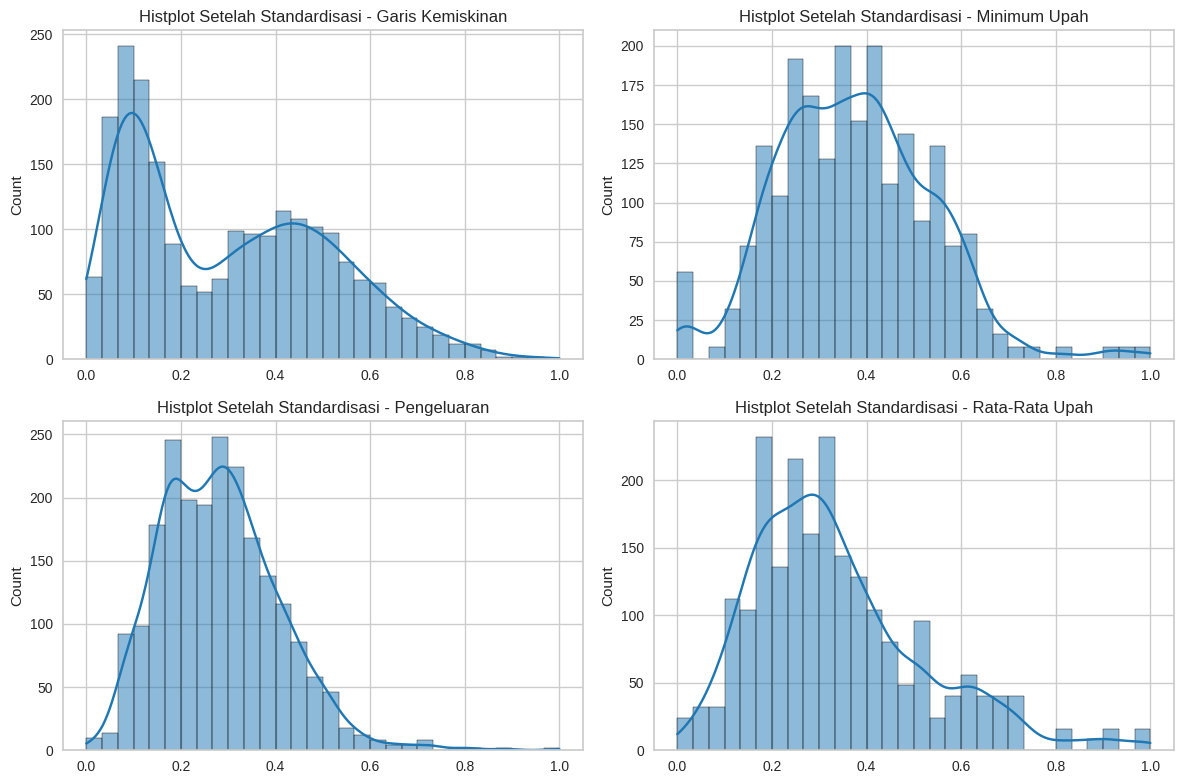

In [561]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.histplot(x=normalisasi_df[col], bins=30, kde=True, color="tab:blue")

    column_name = ""

    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Histplot Setelah Standardisasi - {column_name}")
    plt.xlabel(None)

plt.tight_layout()
plt.show()

**Insight :**  
Menggunakan **MinMaxScaler** karena saya ingin mengubah fitur-fitur numerik ke dalam rentang skala yang seragam antara 0 dan 1. Hal ini sangat penting untuk memastikan bahwa semua fitur memiliki bobot yang seimbang, terutama ketika variabel-variabel tersebut memiliki rentang nilai yang sangat berbeda, seperti `Garis Kemiskinan` yang bernilai ribuan hingga jutaan, dan `Rata-Rata Upah` yang lebih kecil.

4. Deteksi dan Penanganan *Outlier*

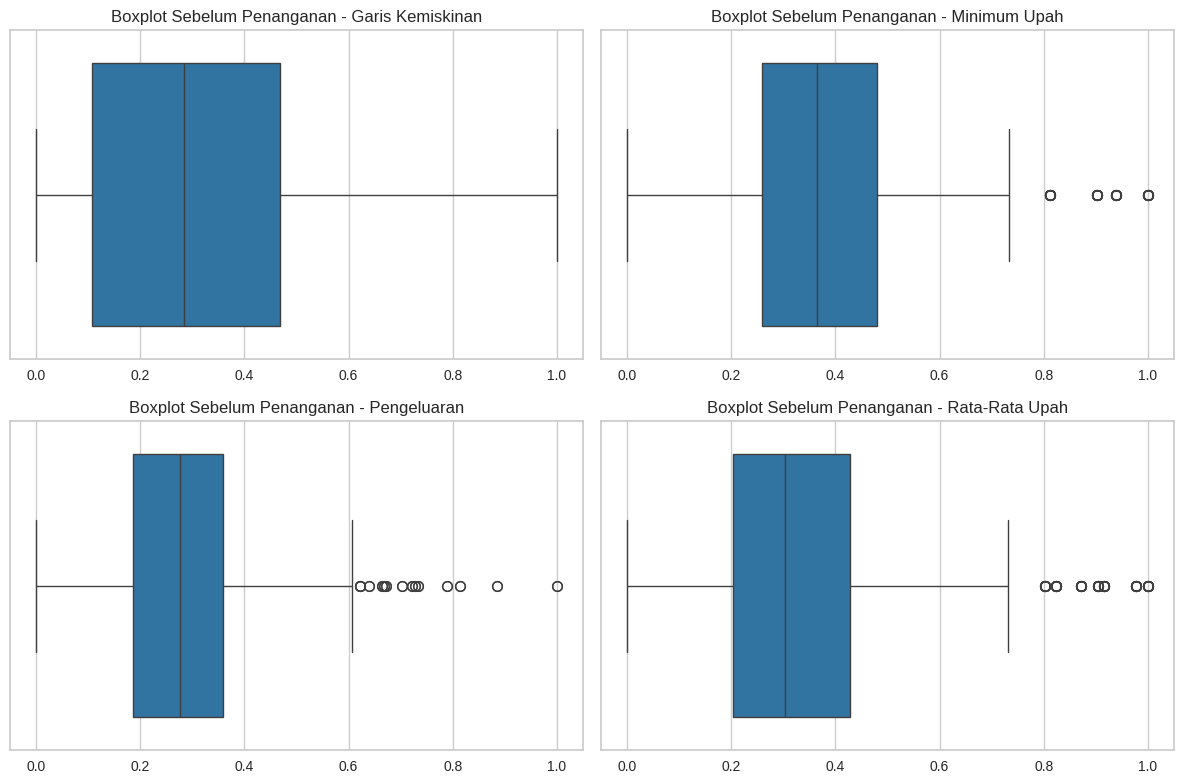

In [562]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=normalisasi_df[col], color="tab:blue")

    column_name = ""

    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Boxplot Sebelum Penanganan - {column_name}")
    plt.xlabel(None)

plt.tight_layout()
plt.show()

In [563]:
def compute_iqr(dataframe, column):
    q1, q3 = dataframe[column].quantile([0.25, 0.75])
    iqr_value = q3 - q1
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    return lower_bound, upper_bound

def find_outliers_iqr(dataframe, column):
    lower, upper = compute_iqr(dataframe, column)
    return dataframe[(dataframe[column] < lower) | (dataframe[column] > upper)]


In [564]:
def handle_outliers_with_iqr(dataframe, column):
    lower, upper = compute_iqr(dataframe, column)
    dataframe[column] = dataframe[column].clip(lower=lower, upper=upper)

outliers_count_before = {column: len(find_outliers_iqr(normalisasi_df, column)) for column in numeric_columns[1:]}
print(f"Jumlah Outliers Sebelum Penanganan: {outliers_count_before}")

Jumlah Outliers Sebelum Penanganan: {'gk': 0, 'ump': 32, 'peng': 28, 'upah': 56}


In [565]:
for column in numeric_columns[1:]:
    handle_outliers_with_iqr(normalisasi_df, column)

outliers_count_after = {column: len(find_outliers_iqr(normalisasi_df, column)) for column in numeric_columns[1:]}
print(f"Jumlah Outliers Setelah Penanganan: {outliers_count_after}")

Jumlah Outliers Setelah Penanganan: {'gk': 0, 'ump': 0, 'peng': 0, 'upah': 0}


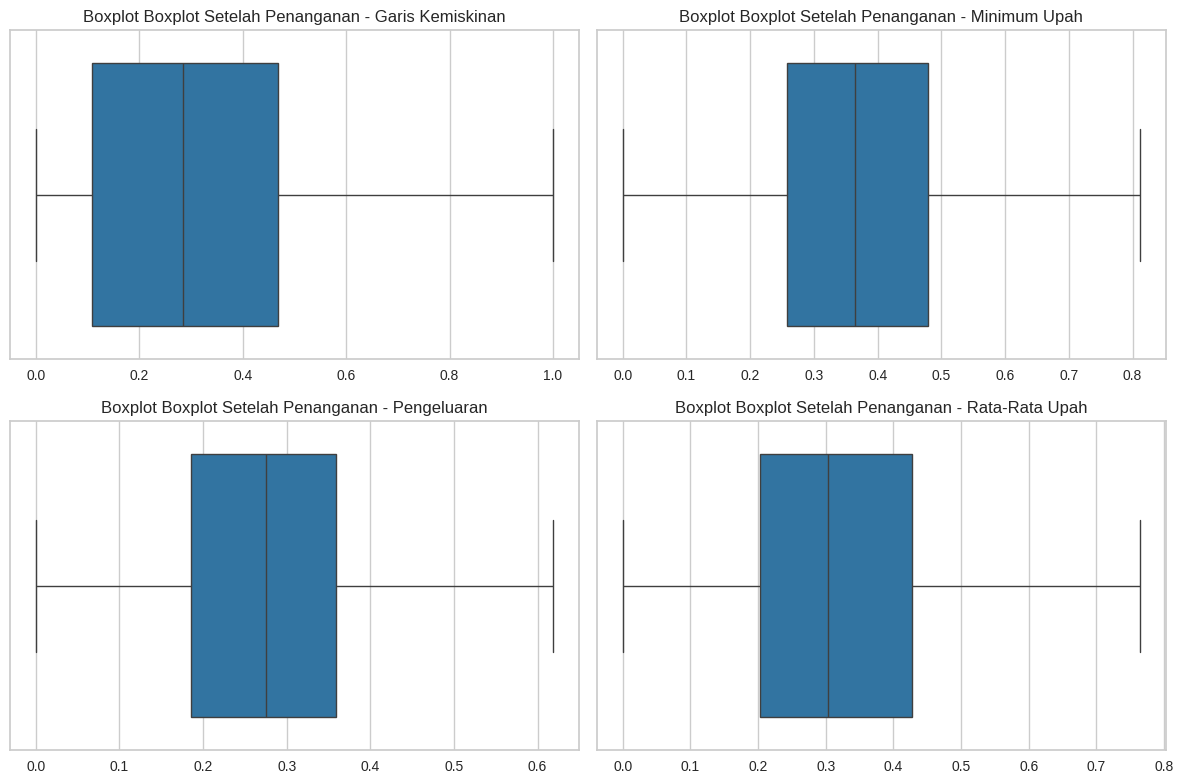

In [566]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns[1:], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=normalisasi_df[col], color="tab:blue")

    column_name = ""

    match col:
        case "gk":
            column_name = "Garis Kemiskinan"
        case "ump":
            column_name = "Minimum Upah"
        case "peng":
            column_name = "Pengeluaran"
        case "upah":
            column_name = "Rata-Rata Upah"

    plt.title(f"Boxplot Boxplot Setelah Penanganan - {column_name}")
    plt.xlabel(None)

plt.tight_layout()
plt.show()

**Insight:**
1. Penanganan outlier berhasil dilakukan pada semua fitur numerik (`ump`, `peng`, dan `upah`)

5. Encoding Data Kategorikal

In [567]:
category_features = ['periode', 'jenis', 'daerah']
normalisasi_df[category_features]

,periode,jenis,daerah
0,MARET,MAKANAN,PERKOTAAN
1,SEPTEMBER,MAKANAN,PERKOTAAN
2,MARET,MAKANAN,PERKOTAAN
3,SEPTEMBER,MAKANAN,PERKOTAAN
4,MARET,MAKANAN,PERDESAAN
...,...,...,...
2171,SEPTEMBER,NONMAKANAN,PERKOTAAN
2172,MARET,NONMAKANAN,PERDESAAN
2173,SEPTEMBER,NONMAKANAN,PERDESAAN
2174,MARET,NONMAKANAN,PERDESAAN


In [568]:
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_data = encoder.fit_transform(normalisasi_df[category_features])
column_names = [str.lower(i) for i in encoder.get_feature_names_out(category_features)]

normalisasi_df[column_names] = encoded_data
normalisasi_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,periode_september,jenis_nonmakanan,daerah_perkotaan
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796,0.0,0.0,1.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796,1.0,0.0,1.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,0.434360,0.323834,0.267067,0.211175,0.0,0.0,1.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,0.457159,0.323834,0.267067,0.211175,1.0,0.0,1.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796,0.0,0.0,0.0


**Insight:**

Melakukan `One-Hot Encoding` untuk mengubah kolom kategorikal jenis dan daerah menjadi format numerik, sehingga model dapat memprosesnya dengan benar tanpa mengasumsikan urutan antar kategori.

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [569]:
processed_df = normalisasi_df.copy()
features = processed_df.select_dtypes(np.number).columns[1:]
processed_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,periode_september,jenis_nonmakanan,daerah_perkotaan
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796,0.0,0.0,1.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796,1.0,0.0,1.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,0.434360,0.323834,0.267067,0.211175,0.0,0.0,1.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,0.457159,0.323834,0.267067,0.211175,1.0,0.0,1.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796,0.0,0.0,0.0


In [570]:
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans_model.fit_predict(processed_df[features])

    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(processed_df[features], cluster_labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(-1)

best_silhouette_score = max(silhouette_scores)
optimal_k_silhouette = k_range[silhouette_scores.index(best_silhouette_score)]
print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters (Silhouette): {optimal_k_silhouette}")

Best Silhouette Score: 0.6880782142507451
Optimal Number of Clusters (Silhouette): 8


**Insight:**
Berdasarkan analisis menggunakan Silhouette Score, jumlah cluster optimal adalah **8** dengan skor tertinggi sebesar **0.688** , menunjukkan bahwa data terbagi menjadi **8** kelompok yang cukup kompak dan terpisah dengan baik.

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

Optimal Number of Clusters (Elbow Method): 4


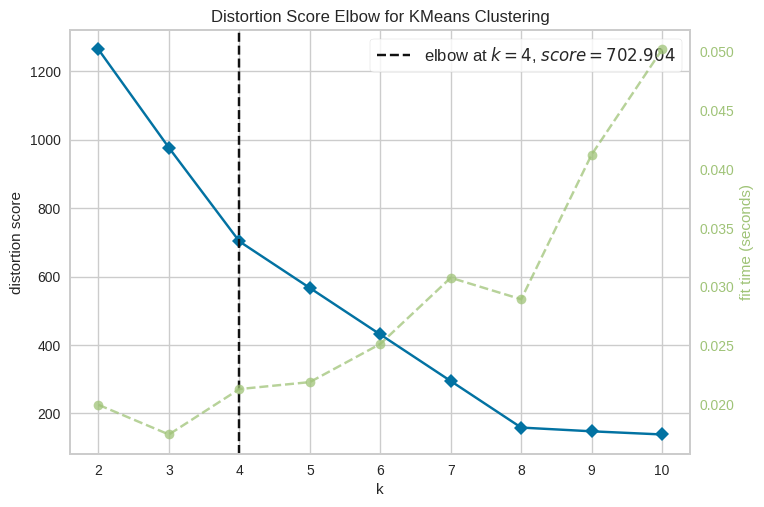

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [571]:
kmeans_model_elbow = KMeans(random_state=42, n_init=10)
elbow_visualizer = KElbowVisualizer(kmeans_model_elbow, k=k_range)
elbow_visualizer.fit(processed_df[features])

optimal_k_elbow = elbow_visualizer.elbow_value_
print(f"Optimal Number of Clusters (Elbow Method): {optimal_k_elbow}")

elbow_visualizer.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


Silhouette Score for Final Model (4 clusters): 0.450868501350269


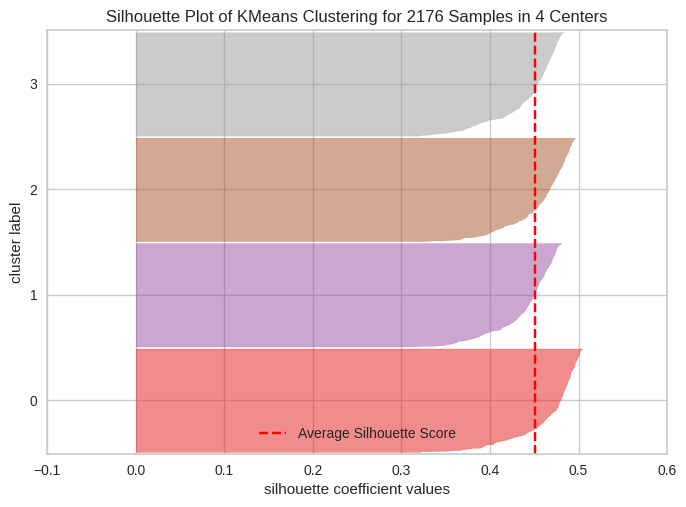

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2176 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [572]:
final_kmeans_model = KMeans(
    n_clusters=optimal_k_elbow,
    init='k-means++',
    n_init=10,
    random_state=42
)
final_kmeans_model.fit(processed_df[features])

# Visualize Silhouette Plot for the final model
silhouette_visualizer = SilhouetteVisualizer(final_kmeans_model)
silhouette_visualizer.fit(processed_df[features])

final_silhouette_score = silhouette_visualizer.silhouette_score_
print(f"Silhouette Score for Final Model ({optimal_k_elbow} clusters): {final_silhouette_score}")

silhouette_visualizer.show()

**Insight:**
1. Berdasarkan grafik **Elbow Method** , jumlah cluster optimal adalah 4 , yang ditandai oleh titik "elbow" pada k = 4. Pada titik ini, penurunan nilai **Distortion Score** (WCSS) menjadi lebih lambat, menunjukkan bahwa tambahan cluster lebih lanjut tidak memberikan manfaat signifikan dalam meningkatkan pemisahan data.
2. Grafik **Silhouette Plot** untuk model dengan **4 cluster** menunjukkan bahwa **Silhouette Score rata-rata** adalah **0.4508** , yang kurang baik tetapi memiliki ruang untuk perbaikan.

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

Optimal Number of Clusters (PCA + Elbow Method): 4


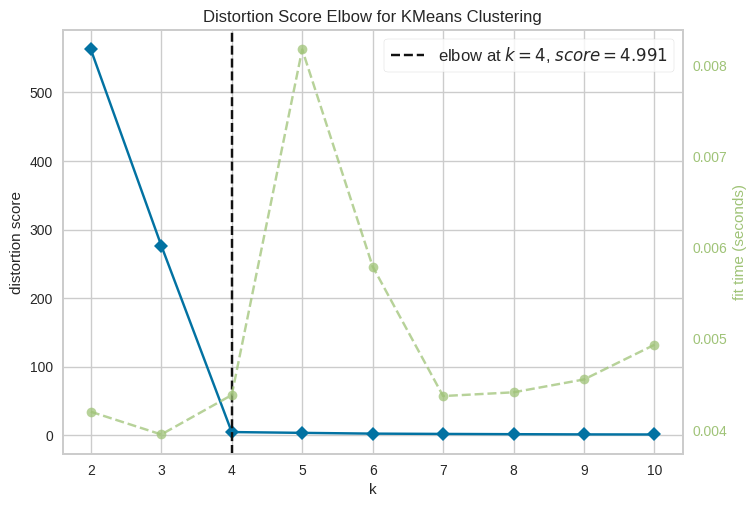

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [573]:
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(processed_df[features])

kmeans_pca_model = KMeans(random_state=42)
pca_elbow_visualizer = KElbowVisualizer(kmeans_pca_model, k=(2, 11))
pca_elbow_visualizer.fit(pca_data)

optimal_k_pca = pca_elbow_visualizer.elbow_value_
print(f"Optimal Number of Clusters (PCA + Elbow Method): {optimal_k_pca}")

pca_elbow_visualizer.show()

In [574]:
pca_kmeans_model = KMeans(n_clusters=optimal_k_pca, random_state=42)
pca_kmeans_model.fit(pca_data)

pca_silhouette_score = silhouette_score(pca_data, pca_kmeans_model.labels_)
print(f"Silhouette Score (PCA-based Clustering): {pca_silhouette_score:.4f}")

Silhouette Score (PCA-based Clustering): 0.9460


**Insgiht:**
1. Penggunaan PCA berhasil mengurangi dimensi data menjadi 2 komponen utama, sambil mempertahankan variabilitas penting. Elbow Method menentukan jumlah cluster optimal menjadi **4**, lebih sedikit dibandingkan hasil clustering tanpa PCA (sebelumnya **8** cluster).
2.  Grafik **Elbow Method** setelah PCA menunjukkan bahwa penurunan WCSS (Within-Cluster Sum of Squares) menjadi lebih tajam pada `k = 4`, mengindikasikan bahwa klaster-klaster yang terbentuk memiliki pemisahan yang lebih baik dibandingkan sebelum PCA. Selain itu, nilai Silhouette Score yang tinggi (0.9460) menunjukkan bahwa titik-titik dalam setiap cluster cenderung kompak dan terpisah dengan jelas.


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

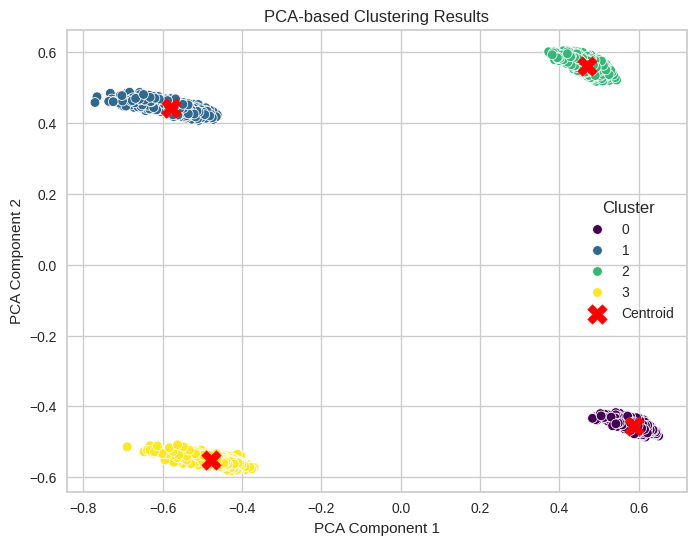

In [575]:
# Visualize PCA-based clustering results
centroids_pca = pca_kmeans_model.cluster_centers_[:, :2]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=pca_kmeans_model.labels_, palette="viridis")
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    marker="X", s=200, c="red", label="Centroid"
)
plt.title("PCA-based Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

**insight :**
Visualisasi hasil clustering menggunakan PCA menunjukkan bahwa data berhasil dibagi menjadi **4 klaster** yang terpisah dengan jelas, dengan setiap klaster memiliki centroid yang berbeda. Klaster 0 dan 1 terkonsentrasi di kiri grafik, sementara klaster 2 dan 3 tersebar lebih luas di sebelah kanan. Centroid masing-masing klaster (ditandai dengan titik silang merah) secara jelas menunjukkan pusat dari setiap kelompok data, memperkuat pemisahan antar klaster.

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [576]:
processed_df["cluster"] = pca_kmeans_model.labels_
normalisasi_df["cluster"] = processed_df["cluster"]
normalisasi_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,periode_september,jenis_nonmakanan,daerah_perkotaan,cluster
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,0.413212,0.265284,0.207971,0.111796,0.0,0.0,1.0,1
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,0.427424,0.265284,0.207971,0.111796,1.0,0.0,1.0,1
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,0.434360,0.323834,0.267067,0.211175,0.0,0.0,1.0,1
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,0.457159,0.323834,0.267067,0.211175,1.0,0.0,1.0,1
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,0.419587,0.265284,0.156954,0.111796,0.0,0.0,0.0,3


### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [577]:
normalisasi_df[columns_to_normalize] = scaler.inverse_transform(normalisasi_df[columns_to_normalize])
normalisasi_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,periode_september,jenis_nonmakanan,daerah_perkotaan,cluster
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226.0,0.0,0.0,1.0,1
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226.0,1.0,0.0,1.0,1
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0,2118500.0,548853.0,13627.0,0.0,0.0,1.0,1
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0,2118500.0,548853.0,13627.0,1.0,0.0,1.0,1
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226.0,0.0,0.0,0.0,3


In [578]:
normalisasi_df.drop(columns=["periode_september","jenis_nonmakanan", "daerah_perkotaan"], inplace=True, axis=1)
normalisasi_df.head()

,provinsi,jenis,daerah,tahun,periode,gk,ump,peng,upah,cluster
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0,1900000.0,466355.0,11226.0,1
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0,1900000.0,466355.0,11226.0,1
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0,2118500.0,548853.0,13627.0,1
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0,2118500.0,548853.0,13627.0,1
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0,1900000.0,395136.0,11226.0,3


Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [579]:
cluster_summary = normalisasi_df.groupby("cluster").agg({
    "periode": lambda x: x.mode().iloc[0],
    "jenis": lambda x: x.mode().iloc[0],
    "daerah": lambda x: x.mode().iloc[0],
    "gk": ['mean', 'max', 'min'],
    "ump": ['mean', 'max', 'min'],
    "peng": ['mean', 'max', 'min'],
    "upah": ['mean', 'max', 'min']
}).reset_index()

cluster_summary.columns = ["cluster" if col[0] == "cluster" else f"{col[0]}_{col[1]}" for col in cluster_summary.columns.to_flat_index()]

for _, row in cluster_summary.iterrows():
    print(f"""
{'Cluster'.ljust(28)}: {row['cluster']}
{'Dominasi Periode'.ljust(28)}: {row['periode_<lambda>']}
{'Dominasi Pengeluaran'.ljust(28)}: {row['jenis_<lambda>']}
{'Dominasi Daerah'.ljust(28)}: {row['daerah_<lambda>']}
{'Rata-Rata Garis Kemiskinan'.ljust(28)}: Rp {math.floor(row['gk_mean']):,}
{'Rata-Rata Minimum Upah'.ljust(28)}: Rp {math.floor(row['ump_mean']):,}
{'Rata-Rata Pengeluaran'.ljust(28)}: Rp {math.floor(row['peng_mean']):,}
{'Rata-Rata Upah'.ljust(28)}: Rp {math.floor(row['upah_mean']):,}
""")



Cluster                     : 0
Dominasi Periode            : MARET
Dominasi Pengeluaran        : NONMAKANAN
Dominasi Daerah             : PERDESAAN
Rata-Rata Garis Kemiskinan  : Rp 105,472
Rata-Rata Minimum Upah      : Rp 2,305,091
Rata-Rata Pengeluaran       : Rp 409,502
Rata-Rata Upah              : Rp 16,567


Cluster                     : 1
Dominasi Periode            : MARET
Dominasi Pengeluaran        : MAKANAN
Dominasi Daerah             : PERKOTAAN
Rata-Rata Garis Kemiskinan  : Rp 339,285
Rata-Rata Minimum Upah      : Rp 2,305,091
Rata-Rata Pengeluaran       : Rp 621,595
Rata-Rata Upah              : Rp 16,567


Cluster                     : 2
Dominasi Periode            : MARET
Dominasi Pengeluaran        : NONMAKANAN
Dominasi Daerah             : PERKOTAAN
Rata-Rata Garis Kemiskinan  : Rp 133,836
Rata-Rata Minimum Upah      : Rp 2,305,091
Rata-Rata Pengeluaran       : Rp 732,004
Rata-Rata Upah              : Rp 16,567


Cluster                     : 3
Dominasi Periode      

In [580]:
def assign_welfare_category(row, cluster_summary):
    median_values = cluster_summary.median()

    if (row['ump'] < median_values['ump'] and
        row['gk'] < median_values['gk'] and
        row['peng'] < median_values['peng'] and
        row['upah'] < median_values['upah']):
        return 'Rendah'
    elif (row['ump'] > median_values['ump'] and
          row['gk'] > median_values['gk'] and
          row['peng'] > median_values['peng'] and
          row['upah'] > median_values['upah']):
        return 'Tinggi'
    else:
        return 'Menengah'

cluster_summary = normalisasi_df.groupby("cluster").agg({
    "ump": "mean",
    "gk": "mean",
    "peng": "mean",
    "upah": "mean"
}).reset_index()

normalisasi_df['kategori_kesejahteraan'] = normalisasi_df.apply(
    assign_welfare_category, args=(cluster_summary,), axis=1
)

for cluster in normalisasi_df['cluster'].unique():
    subset = normalisasi_df[normalisasi_df['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(subset[['provinsi', 'kategori_kesejahteraan']].head())


Cluster 1:
  provinsi kategori_kesejahteraan
0     ACEH               Menengah
1     ACEH               Menengah
2     ACEH               Menengah
3     ACEH               Menengah
8     ACEH               Menengah

Cluster 3:
   provinsi kategori_kesejahteraan
4      ACEH               Menengah
5      ACEH               Menengah
6      ACEH               Menengah
7      ACEH               Menengah
12     ACEH               Menengah

Cluster 2:
   provinsi kategori_kesejahteraan
32     ACEH                 Rendah
33     ACEH                 Rendah
34     ACEH                 Rendah
35     ACEH                 Rendah
40     ACEH               Menengah

Cluster 0:
   provinsi kategori_kesejahteraan
36     ACEH                 Rendah
37     ACEH                 Rendah
38     ACEH                 Rendah
39     ACEH                 Rendah
44     ACEH               Menengah


In [581]:
kategori_per_provinsi = normalisasi_df.groupby(['provinsi', 'kategori_kesejahteraan']).size().unstack(fill_value=0)
print(kategori_per_provinsi)

kategori_kesejahteraan  Menengah  Rendah  Tinggi
provinsi                                        
ACEH                          44       8      12
BALI                          42      16       6
BANTEN                        50       2      12
BENGKULU                      48      14       2
DI YOGYAKARTA                 48      16       0
DKI JAKARTA                   49       0      15
GORONTALO                     44      20       0
JAMBI                         54      10       0
JAWA BARAT                    50      10       4
JAWA TENGAH                   36      28       0
JAWA TIMUR                    43      21       0
KALIMANTAN BARAT              50      14       0
KALIMANTAN SELATAN            45       7      12
KALIMANTAN TENGAH             38       6      20
KALIMANTAN TIMUR              38       2      24
KALIMANTAN UTARA              42       0      22
KEP. BANGKA BELITUNG          50       2      12
KEP. RIAU                     41       0      23
LAMPUNG             

# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

##Cluster 0
* **Dominasi Periode:** Maret
* **Dominasi Pengeluaran:** Nonmakanan
* **Dominasi Daerah:** Perdesaan
* **Rata-Rata Garis Kemiskinan:** Rp 105.472
* **Rata-Rata Minimum Upah:** Rp 2.305.091
* **Rata-Rata Pengeluaran:** Rp 409.502
* **Rata-Rata Upah:** Rp 16.567

**Insight:**
`Cluster 0` merepresentasikan **daerah perdesaan** yang memiliki kecenderungan belanja ke arah **nonmakanan** seperti transportasi, pendidikan, atau kebutuhan rumah tangga lainnya. Meskipun berada di desa, mereka sudah melewati titik fokus pemenuhan kebutuhan dasar makanan. Namun, **garis kemiskinan yang rendah** menunjukkan bahwa standar hidup di daerah ini masih relatif murah—atau bisa juga karena daya beli yang terbatas. Rata-rata pengeluaran di bawah Rp 500 ribu menunjukkan bahwa **konsumsi** masyarakat **masih dibatasi oleh pendapatan**. Sebagian besar provinsi seperti **ACEH**, dalam cluster ini, menunjukkan pola tersebut dengan dominasi kategori **Rendah**, namun ada juga yang **Menengah**, menunjukkan adanya perbedaan tingkat daya beli antar wilayah.


##Cluster 1
* **Dominasi Periode:** Maret
* **Dominasi Pengeluaran:** Makanan
* **Dominasi Daerah:** Perkotaan
* **Rata-Rata Garis Kemiskinan:** Rp 339.285
* **Rata-Rata Minimum Upah:** Rp 2.305.091
* **Rata-Rata Pengeluaran:** Rp 621.595
* **Rata-Rata Upah:** Rp 16.567

**Insight:**
Cluster 1 menggambarkan **wilayah perkotaan** yang masih **mengalokasikan pengeluaran utamanya untuk makanan**. Ini adalah situasi menarik karena meskipun berada di kota (yang biasanya lebih makmur), sebagian besar masyarakat masih fokus pada pemenuhan kebutuhan dasar.Rata-rata garis kemiskinan dan pengeluaran di atas Cluster 0, menunjukkan bahwa biaya **hidup di kota lebih tinggi,** namun pengeluaran masih belum menjangkau sektor nonmakanan secara luas.  Dominasi provinsi seperti **ACEH, Sulawesi,** atau **Sumatera bagian tengah** memperlihatkan keseimbangan antara urbanisasi dan keterbatasan daya beli.

##Cluster 2
* **Dominasi Periode:** Maret
* **Dominasi Pengeluaran:** Nonmakanan
* **Dominasi Daerah:** Perkotaan
* **Rata-Rata Garis Kemiskinan:** Rp 133.836
* **Rata-Rata Minimum Upah:** Rp 2.305.091
* **Rata-Rata Pengeluaran:** Rp 732.004
* **Rata-Rata Upah:** Rp 16.567

**Insight:**
Cluster 2 menunjukkan **wilayah perkotaan yang sudah lebih mapan**, di mana **belanja nonmakanan** mendominasi. Ini merefleksikan masyarakat yang kebutuhan dasarnya sudah terpenuhi, sehingga alokasi pengeluaran bergeser ke kebutuhan sekunder dan tersier—seperti pendidikan, transportasi, dan hiburan.Garis kemiskinan yang cukup rendah dan pengeluaran yang tertinggi di antara semua cluster mengindikasikan bahwa **masyarakat di sini memiliki kapasitas belanja lebih besar**. Menariknya, provinsi seperti **ACEH** yang masuk ke cluster ini banyak dikategorikan sebagai **Rendah**. Ini bisa terjadi karena ketimpangan daya beli atau kesenjangan antarwilayah dalam provinsi itu sendiri.

##Cluster 3
* **Dominasi Periode:** Maret
* **Dominasi Pengeluaran:** Makanan
* **Dominasi Daerah:** Perdesaan
* **Rata-Rata Garis Kemiskinan:** Rp 333.544
* **Rata-Rata Minimum Upah:** Rp 2.305.091
* **Rata-Rata Pengeluaran:** Rp 509.200
* **Rata-Rata Upah:** Rp 16.567

**Insight:**
Cluster 3 cukup unik karena meskipun **dominan di daerah perdesaan, pengeluaran untuk makanan masih sangat tinggi.** Hal ini memperlihatkan bahwa masyarakat desa dalam cluster ini **belum keluar dari lingkaran konsumsi kebutuhan dasar.** Garis kemiskinan tinggi namun pengeluaran dan upah tergolong sedang, menunjukkan **ketidakseimbangan antara kebutuhan dan pendapatan.** Provinsi **ACEH** dan wilayah lainnya mendominasi dalam bentuk **kategori menengah,** yang artinya masih bisa naik kelas kesejahteraan bila daya beli dan pendapatan meningkat.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [582]:
normalisasi_df.to_csv("/content/drive/MyDrive/submission2/dataset/Dataset_inisiasi.csv", index=False)